In [1]:
import sys
sys.path.append("..")

from glob import glob
import matplotlib.pyplot as plt
import ipywidgets as ipw
import numpy as np 
from tqdm.notebook import tqdm

from imitative_agent import ImitativeAgent
from lib.dataset_wrapper import Dataset
from lib import utils
from lib import abx_utils

In [2]:
ABX_NB_SAMPLES = 50
AGENT_ABX_DISTANCES = [
    {
        "art_estimated": {
            "metric": "euclidean",
            "weight": 1,
        },
    }
]

In [3]:
agents_path = glob("../out/imitative_agent/*/")
agents_path.sort()

agents_alias = {}

for agent_path in agents_path:
    agent = ImitativeAgent.reload(agent_path, load_nn=False)
    config = agent.config
        
    agent_i = agent_path[-2]
    agent_alias = " ".join((
        f"{','.join(config['dataset']['names'])}",
        f"synth_art={agent.synthesizer.config['dataset']['art_type']}",
        f"jerk_c={config['training']['jerk_loss_ceil']}",
        f"jerk_w={config['training']['jerk_loss_weight']}",
        f"bi={config['model']['inverse_model']['bidirectional']}",
        f"({agent_i})",
    ))
    
    agents_alias[agent_alias] = agent_path

In [4]:
agents_abx_matrices = utils.pickle_load("../out/imitative_agent/abx_cache.pickle", {})

for agent_alias, agent_path in tqdm(agents_alias.items()):
    agent = ImitativeAgent.reload(agent_path)
    
    main_dataset = agent.get_main_dataset()
    agent_lab = agent.get_datasplit_lab(2)
    agent_features = agent.repeat_datasplit(2)

    consonants = main_dataset.phones_infos["consonants"]
    vowels = main_dataset.phones_infos["vowels"]
    consonants_indexes = abx_utils.get_datasets_phones_indexes(agent_lab, consonants, vowels)
    
    if agent_path not in agents_abx_matrices:
        agents_abx_matrices[agent_path] = {}
    agent_abx_matrices = agents_abx_matrices[agent_path]
    
    for distance in AGENT_ABX_DISTANCES:
        distance_signature = abx_utils.get_distance_signature(distance)
        if distance_signature in agent_abx_matrices: continue
        abx_matrix = abx_utils.get_abx_matrix(consonants, consonants_indexes, agent_features, distance, ABX_NB_SAMPLES)
        
        agent_abx_matrices[distance_signature] = abx_matrix
        utils.pickle_dump("../out/imitative_agent/abx_cache.pickle", agents_abx_matrices)

  0%|          | 0/48 [00:00<?, ?it/s]

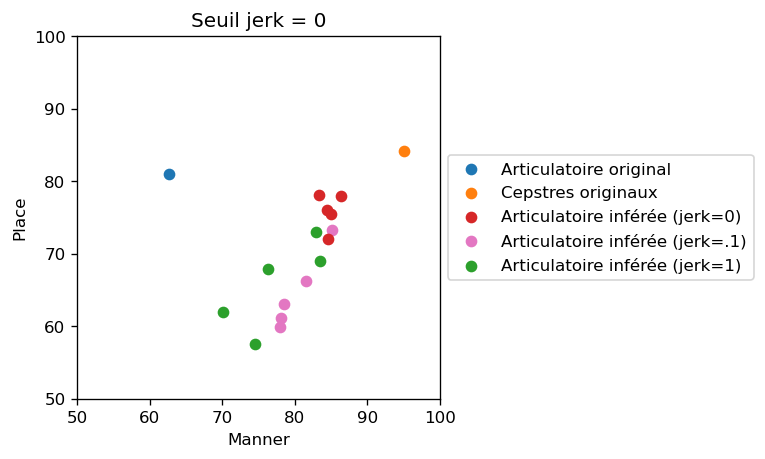

In [6]:
CEIL = 0

# # plosives + fricatives
# abx_art_params = {'manner': 62.73333333333334, 'place': 80.25}
# abx_cepstrum = {'manner': 95.3, 'place': 73.75}
# fricatives only
abx_art_params = {'manner': 62.63333333333333, 'place': 81.0}
abx_cepstrum = {'manner': 95.1, 'place': 84.16666666666667}

for distance in AGENT_ABX_DISTANCES:
    distance_signature = abx_utils.get_distance_signature(distance)
    
    plt.figure(dpi=120)
    ax = plt.subplot(aspect="equal")
    ax.set_xlim(50, 100)
    ax.set_ylim(50, 100)
    ax.set_xlabel("Manner")
    ax.set_ylabel("Place")
    
    ax.set_title("Seuil jerk = %s" % CEIL)
    
    ax.scatter(abx_art_params["manner"], abx_art_params["place"], c="tab:blue", label="Articulatoire original")
    ax.scatter(abx_cepstrum["manner"], abx_cepstrum["place"], c="tab:orange", label="Cepstres originaux")
    
    ax.scatter(0, 0, c="tab:red", label="Articulatoire inférée (jerk=0)")
    ax.scatter(0, 0, c="tab:pink", label="Articulatoire inférée (jerk=.1)")
    ax.scatter(0, 0, c="tab:green", label="Articulatoire inférée (jerk=1)")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    for agent_alias, agent_path in agents_alias.items():
        agent = ImitativeAgent.reload(agent_path, load_nn=False)
        dataset = agent.get_main_dataset()
        
        color = "tab:red"
        if agent.config["training"]["jerk_loss_weight"] == .1:
            color = "tab:pink"
        if agent.config["training"]["jerk_loss_weight"] == 1:
            color = "tab:green"
        if agent.config["model"]["inverse_model"]["bidirectional"] == True:
            color = "tab:cyan"
            continue
        if agent.config["training"]["jerk_loss_ceil"] != CEIL:
            continue

        agent_abx_matrix = agents_abx_matrices[agent_path][distance_signature]
        
        consonant_groups = dataset.phones_infos["consonant_groups"].copy()
        # consonant_groups["manner"] = [['f', 'v', 'm'], ['s', 'z', 'n'], ['s^', 'z^', 'r']]
        consonant_groups["place"] = [['f', 's', 's^'], ['v', 'z', 'z^']]
        # consonant_groups["place"] = [['p', 't', 'k'], ['b', 'd', 'g']]
        
        agent_groups_score = abx_utils.get_groups_score(consonants, agent_abx_matrix, consonant_groups)
        ax.scatter(agent_groups_score["manner"], agent_groups_score["place"], c=color)
    
    plt.show()